<a href="https://colab.research.google.com/github/LinggarM/Comparison-of-Ensemble-Learning-Methods-on-Diabetes-Disease-Classification/blob/main/pba_tugas_besar_movie_synopsis_text_clustering_8000_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retrieve Data 

In [ ]:
import json
import requests

## Retrieve Genres

In [ ]:
# Get All Genres

genres = []
for i in range(1000) :
  url = ("https://api.themoviedb.org/3/movie/%d?api_key=63fea4c709da1f1496b7a1ca7a3c6083" % i)
  r = requests.get(url)
  json_data = json.loads(r.text)
  try:
    if (json_data['genres'] != "") :
      # print(json_data['genres'])
      for j in json_data['genres'] :
        genre = j.get('name')
        if (genre not in genres) :
          genres.append(genre)
  except Exception:
    pass
print(genres)

['Drama', 'Crime', 'Comedy', 'Action', 'Thriller', 'Documentary', 'Adventure', 'Science Fiction', 'Animation', 'Family', 'Romance', 'Mystery', 'Horror', 'Fantasy', 'War', 'Music', 'History', 'Western', 'TV Movie']


In [ ]:
len(genres)

19

## Retrieve Titles & Synopsis

In [ ]:
titles = []
synopsis = []

for i in range(100000) :
  url = ("https://api.themoviedb.org/3/movie/%d?api_key=63fea4c709da1f1496b7a1ca7a3c6083" % i)
  r = requests.get(url)
  json_data = json.loads(r.text)
  try:
    if (json_data['overview'] != "" and json_data['overview'] != "No overview found." and json_data['original_language'] == 'en') :
      titles.append(json_data['title'])
      synopsis.append(json_data['overview'])
      # print(json_data['original_language'], json_data['release_date'], json_data['id'], ". ", json_data['title'], " : ", json_data['overview'])
      # print("\n")
  except Exception:
    pass

In [ ]:
import pandas as pd

df_movies = pd.DataFrame({'title': titles, 'synopsis': synopsis})

In [ ]:
df_movies.head()

,title,synopsis
0,Four Rooms,It's Ted the Bellhop's first night on the job....
1,Judgment Night,"While racing to a boxing match, Frank, Mike, J..."
2,Life in Loops (A Megacities RMX),Timo Novotny labels his new project an experim...
3,Star Wars,Princess Leia is captured and held hostage by ...
4,Finding Nemo,"Nemo, an adventurous young clownfish, is unexp..."


In [ ]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44096 entries, 0 to 44095
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     44096 non-null  object
 1   synopsis  44096 non-null  object
dtypes: object(2)
memory usage: 689.1+ KB


In [ ]:
df_movies = df_movies.drop(df_movies.index[20000:], axis = 0)
df_movies

,title,synopsis
0,Four Rooms,It's Ted the Bellhop's first night on the job....
1,Judgment Night,"While racing to a boxing match, Frank, Mike, J..."
2,Life in Loops (A Megacities RMX),Timo Novotny labels his new project an experim...
3,Star Wars,Princess Leia is captured and held hostage by ...
4,Finding Nemo,"Nemo, an adventurous young clownfish, is unexp..."
...,...,...
19995,Vanishing on 7th Street,A mysterious global blackout yields countless ...
19996,"Joe Satriani - Live - The Grove in Anaheim, Ca...","Guitarist Joe Satriani playing In Anaheim, Cal..."
19997,Along the Great Divide,New Federal marshal Len Merrick saves Tim Keit...
19998,StarGaze HD: Universal Beauty,StarGaze HD brings the beauty and majesty of t...


In [ ]:
with open('/content/gdrive/MyDrive/Upload/movie_synopsis.csv', 'w') as f:
  df_movies.to_csv(f)

# Data Preprocessing

## Import Data

In [1]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
import pandas as pd

df_movies = pd.read_csv('/content/gdrive/MyDrive/Upload/Akademik/Tugas Besar PBA/movie_synopsis_8000_no overview.csv', lineterminator='\n')
df_movies.head()

,title,synopsis
0,Four Rooms,It's Ted the Bellhop's first night on the job....
1,Judgment Night,"While racing to a boxing match, Frank, Mike, J..."
2,Life in Loops (A Megacities RMX),Timo Novotny labels his new project an experim...
3,Star Wars,Princess Leia is captured and held hostage by ...
4,Finding Nemo,"Nemo, an adventurous young clownfish, is unexp..."


In [5]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8457 entries, 0 to 8456
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     8457 non-null   object
 1   synopsis  8457 non-null   object
dtypes: object(2)
memory usage: 132.3+ KB


## Delete Missing Value

In [6]:
# Get names of indexes for which column Age has value 30
index_drop = df_movies[df_movies['synopsis'] == "No overview found."].index
# Delete these row indexes from dataFrame
df_movies.drop(index_drop , inplace=True)

In [7]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8214 entries, 0 to 8456
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     8214 non-null   object
 1   synopsis  8214 non-null   object
dtypes: object(2)
memory usage: 192.5+ KB


## Case Folding

In [9]:
df_movies["synopsis"] = df_movies["synopsis"].str.lower()
df_movies.head()

,title,synopsis
0,Four Rooms,it's ted the bellhop's first night on the job....
1,Judgment Night,"while racing to a boxing match, frank, mike, j..."
2,Life in Loops (A Megacities RMX),timo novotny labels his new project an experim...
3,Star Wars,princess leia is captured and held hostage by ...
4,Finding Nemo,"nemo, an adventurous young clownfish, is unexp..."


## TF-IDF Training

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
features = vectorizer.fit_transform(df_movies['synopsis'].values) # training vector TF-IDF pada tiap data

# vector TF-IDF tiap kalimat (features), pasangan index kata dan nilainya
for i in features :
  print(i)
  print('-----------------------------')

Streaming output truncated to the last 5000 lines.
  (0, 12973)	0.14483275104625953
  (0, 13149)	0.13334586172540167
  (0, 24957)	0.13582667519419955
  (0, 19440)	0.15240864127004877
  (0, 22836)	0.1473720700967724
  (0, 13120)	0.17393621751782645
  (0, 8265)	0.1513027940750261
  (0, 8289)	0.11682112768112195
  (0, 25181)	0.13863052877378373
  (0, 9008)	0.13863052877378373
  (0, 24913)	0.12196110094053371
  (0, 3447)	0.1071559827980113
  (0, 26174)	0.11682112768112195
  (0, 9127)	0.12797983875545338
  (0, 18845)	0.11111454318249671
  (0, 5267)	0.13112128247827526
  (0, 10409)	0.09228187772399131
  (0, 3986)	0.13112128247827526
  (0, 15067)	0.10757735048365544
  (0, 27070)	0.07234665066262949
  (0, 9308)	0.08432181315756035
-----------------------------
  (0, 12857)	0.2131956414188282
  (0, 7006)	0.20392116623243212
  (0, 17420)	0.20392116623243212
  (0, 24874)	0.1814860013138223
  (0, 14253)	0.20392116623243212
  (0, 12384)	0.1845403543585994
  (0, 5709)	0.16710741411314206
  (0, 25391

In [115]:
import pickle

# Save Model
pickle.dump(vectorizer, open('/content/gdrive/MyDrive/Upload/Akademik/Tugas Besar PBA/vectorizer.sav', 'wb'))

# KMeans Model Training

In [80]:
from sklearn.cluster import KMeans

k = 19 # jumlah cluster
kmeans_model = KMeans(n_clusters = k, n_init = 3, max_iter = 500)
synopsis_clusters = kmeans_model.fit(features)

In [82]:
import pickle

# Save Model
pickle.dump(kmeans_model, open('/content/gdrive/MyDrive/Upload/Akademik/Tugas Besar PBA/kmeans_model.sav', 'wb'))

In [83]:
# Load Model
kmeans_model = pickle.load(open('/content/gdrive/MyDrive/Upload/Akademik/Tugas Besar PBA/kmeans_model.sav', 'rb'))

# Data Labelling

In [104]:
df_movies['label'] = kmeans_model.labels_
df_movies.head()

,title,synopsis,label
0,Four Rooms,it's ted the bellhop's first night on the job....,3
1,Judgment Night,"while racing to a boxing match, frank, mike, j...",3
2,Life in Loops (A Megacities RMX),timo novotny labels his new project an experim...,9
3,Star Wars,princess leia is captured and held hostage by ...,3
4,Finding Nemo,"nemo, an adventurous young clownfish, is unexp...",13


# Data Preview for each Cluster

In [105]:
clusters = df_movies.groupby('label')

for cluster in clusters.groups :
  print("Cluster %d : " % cluster)
  data_cluster = clusters.get_group(cluster)[['title','synopsis']]
  for i in range(5) :
    data = data_cluster.iloc[i]
    print('   ', data['title'], ': ', data['synopsis'])
  print('\n')

Cluster 0 : 
    Brazil :  low-level bureaucrat sam lowry escapes the monotony of his day-to-day life through a recurring daydream of himself as a virtuous hero saving a beautiful damsel. investigating a case that led to the wrongful arrest and eventual death of an innocent man instead of wanted terrorist harry tuttle, he meets the woman from his daydream, and in trying to help her gets caught in a web of mistaken identities, mindless bureaucracy and lies.
    The Secret Life of Words :  a touching story of a deaf girl who is sent to an oil rig to take care of a man who has been blinded in a terrible accident. the girl has a special ability to communicate with the men on board and especially with her patient as they share intimate moments together that will change their lives forever.
    North by Northwest :  advertising man roger thornhill is mistaken for a spy, triggering a deadly cross-country chase.
    Indiana Jones and the Kingdom of the Crystal Skull :  set during the cold war,

# Save All Data from each Cluster

In [106]:
clusters = df_movies.groupby('label')

for cluster in clusters.groups :
    f = open('cluster'+str(cluster)+ '.csv', 'w') # buat file csv untuk tiap cluster
    data = clusters.get_group(cluster)[['title','synopsis']] # judul dan sinposis tiap data pada tiap cluster
    f.write(data.to_csv(index_label='id')) # simpan ke csv
    f.close()

# Feature Names of each Cluster

In [107]:
order_centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1] # diurutkan berdasarkan indeks -> lalu di-reversed
terms = vectorizer.get_feature_names()
n_terms = 10

for i in range(k) :
	print("Cluster %d :" % i)
	for j in order_centroids [i, :n_terms] :
		print('   %s' % terms[j])
	print('----------')

Cluster 0 :
   man
   story
   life
   true
   young
   based
   woman
   death
   men
   finds
----------
Cluster 1 :
   town
   small
   sheriff
   woman
   new
   local
   comes
   life
   murder
   mysterious
----------
Cluster 2 :
   war
   world
   ii
   vietnam
   soldiers
   american
   civil
   army
   story
   german
----------
Cluster 3 :
   life
   young
   time
   help
   finds
   woman
   killer
   friends
   night
   police
----------
Cluster 4 :
   money
   cash
   make
   million
   mike
   steals
   wants
   large
   come
   young
----------
Cluster 5 :
   new
   york
   city
   life
   young
   love
   world
   apartment
   man
   police
----------
Cluster 6 :
   group
   earth
   planet
   ship
   alien
   space
   crew
   mission
   soon
   human
----------
Cluster 7 :
   event
   ufc
   championship
   held
   ultimate
   mixed
   martial
   arts
   fighting
   pride
----------
Cluster 8 :
   american
   african
   young
   america
   man
   world
   story
   mexi

Cluster: 0


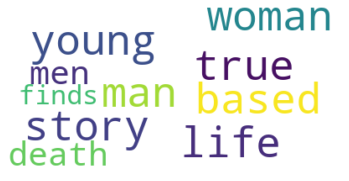

Cluster: 1


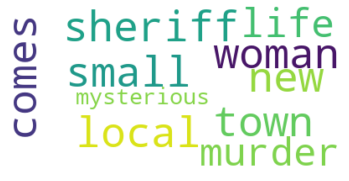

Cluster: 2


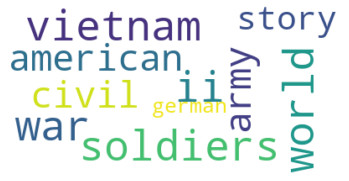

Cluster: 3


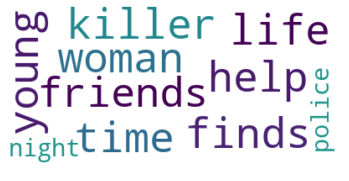

Cluster: 4


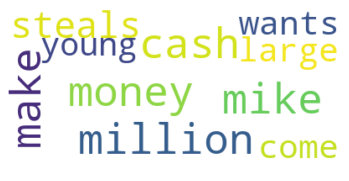

Cluster: 5


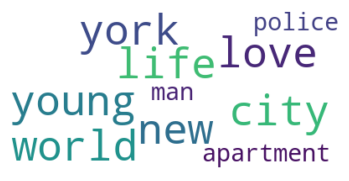

Cluster: 6


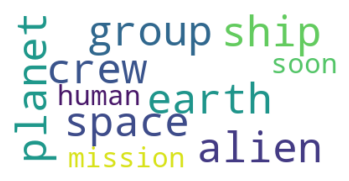

Cluster: 7


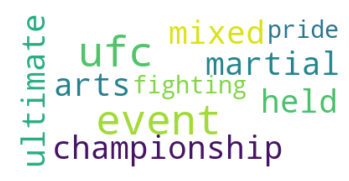

Cluster: 8


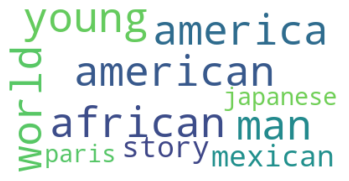

Cluster: 9


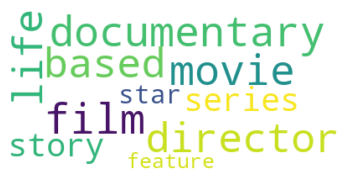

Cluster: 10


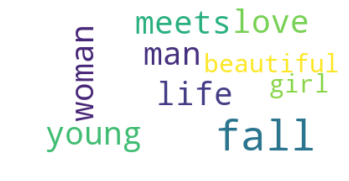

Cluster: 11


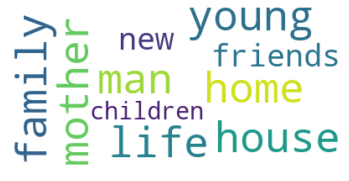

Cluster: 12


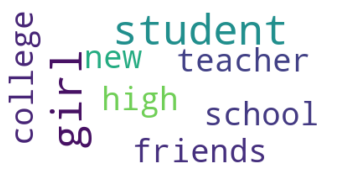

Cluster: 13


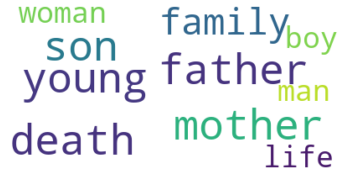

Cluster: 14


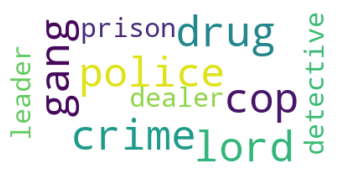

Cluster: 15


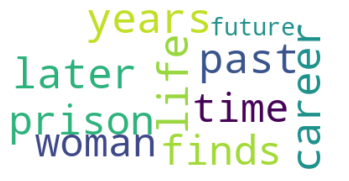

Cluster: 16


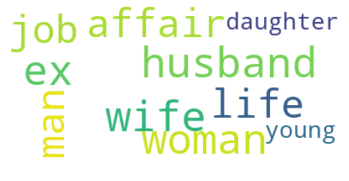

Cluster: 17


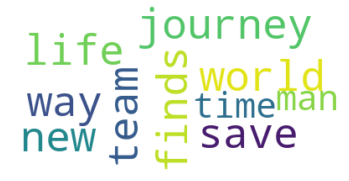

Cluster: 18


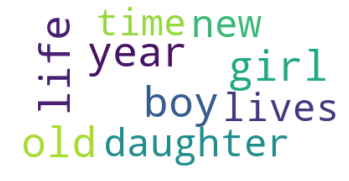

In [108]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

c = []
keywords = []
for i in range(k) :
  c.append(i)
  key = ""
  for j in order_centroids [i, :n_terms] :
    key = key+(" ")+(terms[j])
  keywords.append(key)

for i in range(k) :
  print('Cluster: %d' % c[i])
  text = keywords[i]
  wordcloud = WordCloud(max_font_size=50, background_color="white").generate(text)
  plt.figure()
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.show()


# Predict Sentences

In [112]:
Sentence = ["Britain declared war on Germany in september 1939 and begin world war 2"]
Y = vectorizer.transform(Sentence)
prediction = kmeans_model.predict(Y)
cluster_prediction = prediction[0]
print("Sentence           : ", Sentence[0])
print("Cluster predicted  : ", cluster_prediction)

Sentence           :  Britain declared war on Germany in september 1939 and begin world war 2
Cluster predicted  :  2


In [110]:
Sentence = ["Johnstone's Family is very nice family"]
Y = vectorizer.transform(Sentence)
prediction = kmeans_model.predict(Y)
cluster_prediction = prediction[0]
print("Sentence           : ", Sentence[0])
print("Cluster predicted  : ", cluster_prediction)

Sentence           :  Johnstone's Family is very nice family
Cluster predicted  :  11


In [111]:
Sentence = ["There are a lot of aliens at space"]
Y = vectorizer.transform(Sentence)
prediction = kmeans_model.predict(Y)
cluster_prediction = prediction[0]
print("Sentence           : ", Sentence[0])
print("Cluster predicted  : ", cluster_prediction)

Sentence           :  There are a lot of aliens at space
Cluster predicted  :  6


# Evaluation

## Elbow Method (SSE)

In [87]:
SSE = []
K = range(3,30)
for n_k in K:
  kmeans_model_iteration = KMeans(n_clusters = n_k).fit(features)
  SSE.append(kmeans_model_iteration.inertia_)

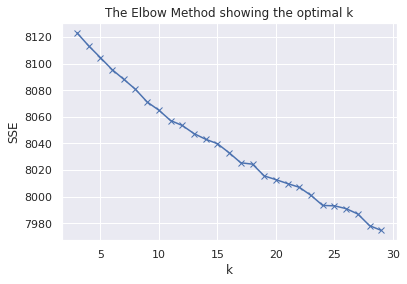

In [88]:
import matplotlib.pyplot as plt

plt.plot(K, SSE, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

## Silhouette Score

In [103]:
from sklearn.metrics import silhouette_score

# nilai silhouette score antara -1 dan 1, semakin tinggil semakin bagus
print(f'Silhouette Score : {silhouette_score(features, labels = kmeans_model.labels_)}')

Silhouette Score : 0.004443204039335572


# Data Visualization

## 2 Dimensi

### PCA Dimensionality Reduction

In [36]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
reduced_features = pca.fit_transform(features.toarray())
reduced_cluster_centers = pca.transform(synopsis_clusters.cluster_centers_)

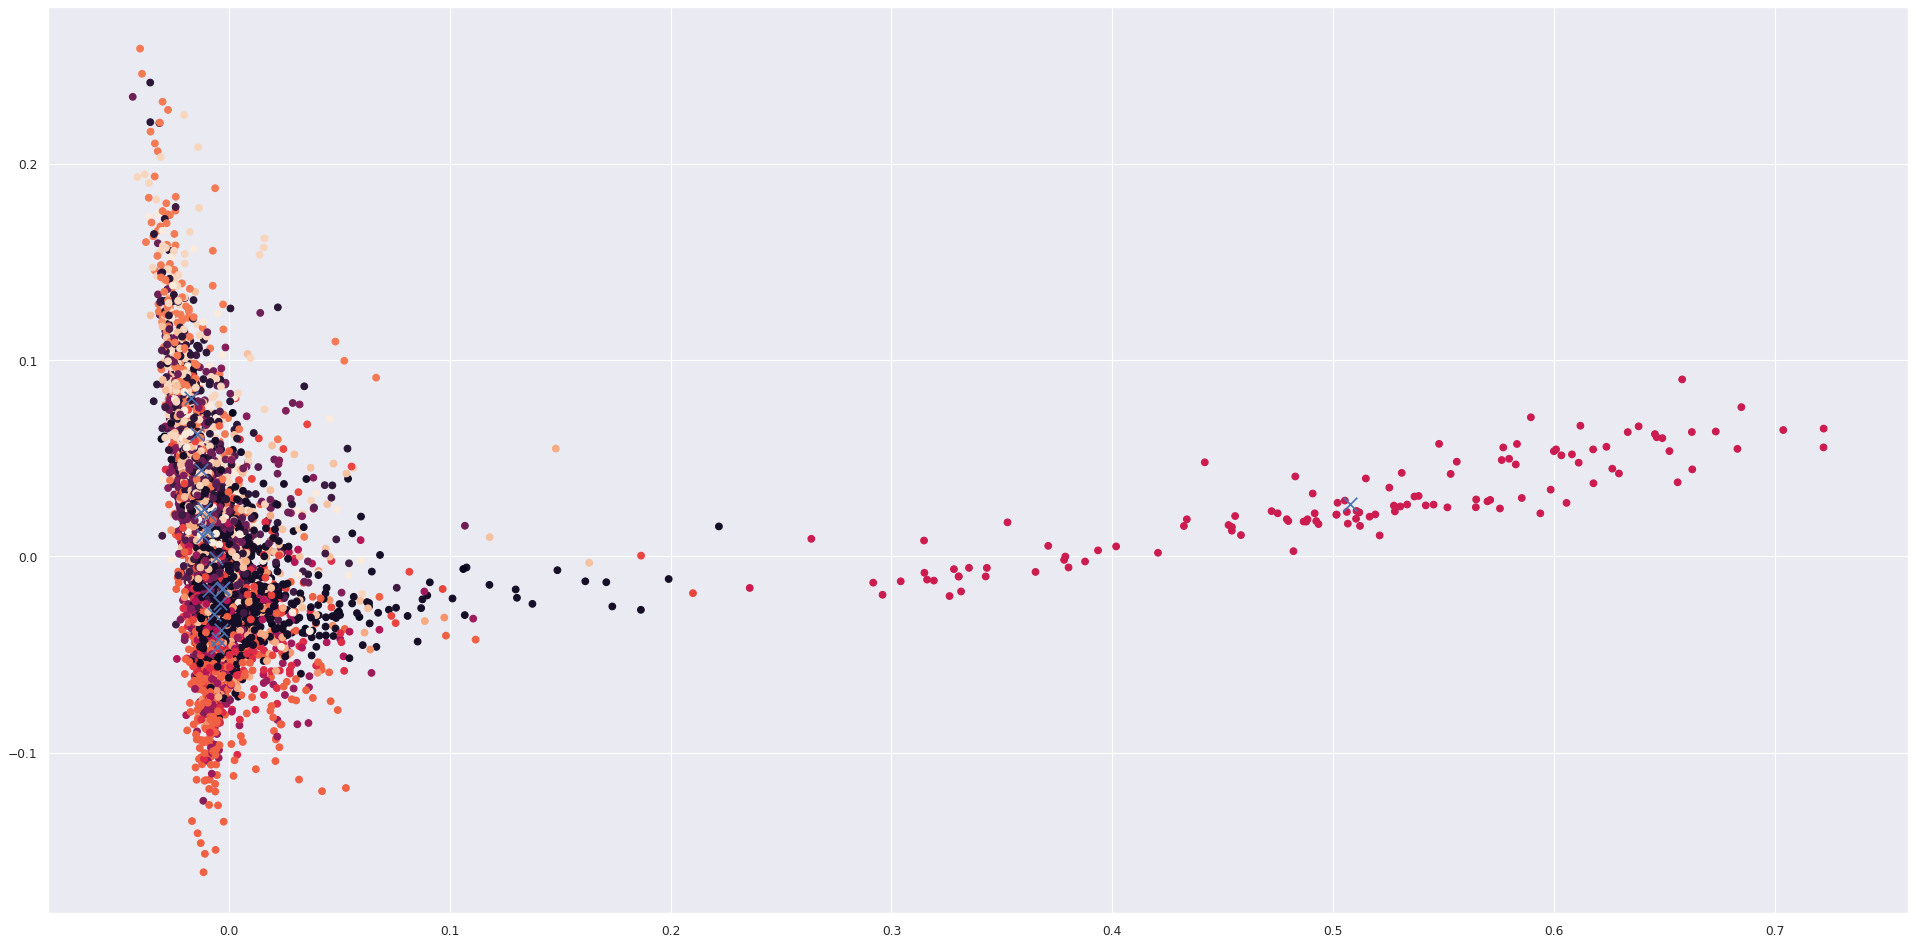

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 15), dpi=80)
plt.scatter(reduced_features[:, 0], reduced_features[:,1], c = kmeans_model.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

### t-SNE Dimensionality Reduction

In [89]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
reduced_features_tsne = tsne.fit_transform(features.toarray())

In [91]:
import pickle

# Save Model
pickle.dump(tsne, open('/content/gdrive/MyDrive/Upload/Akademik/Tugas Besar PBA/tsne.sav', 'wb'))

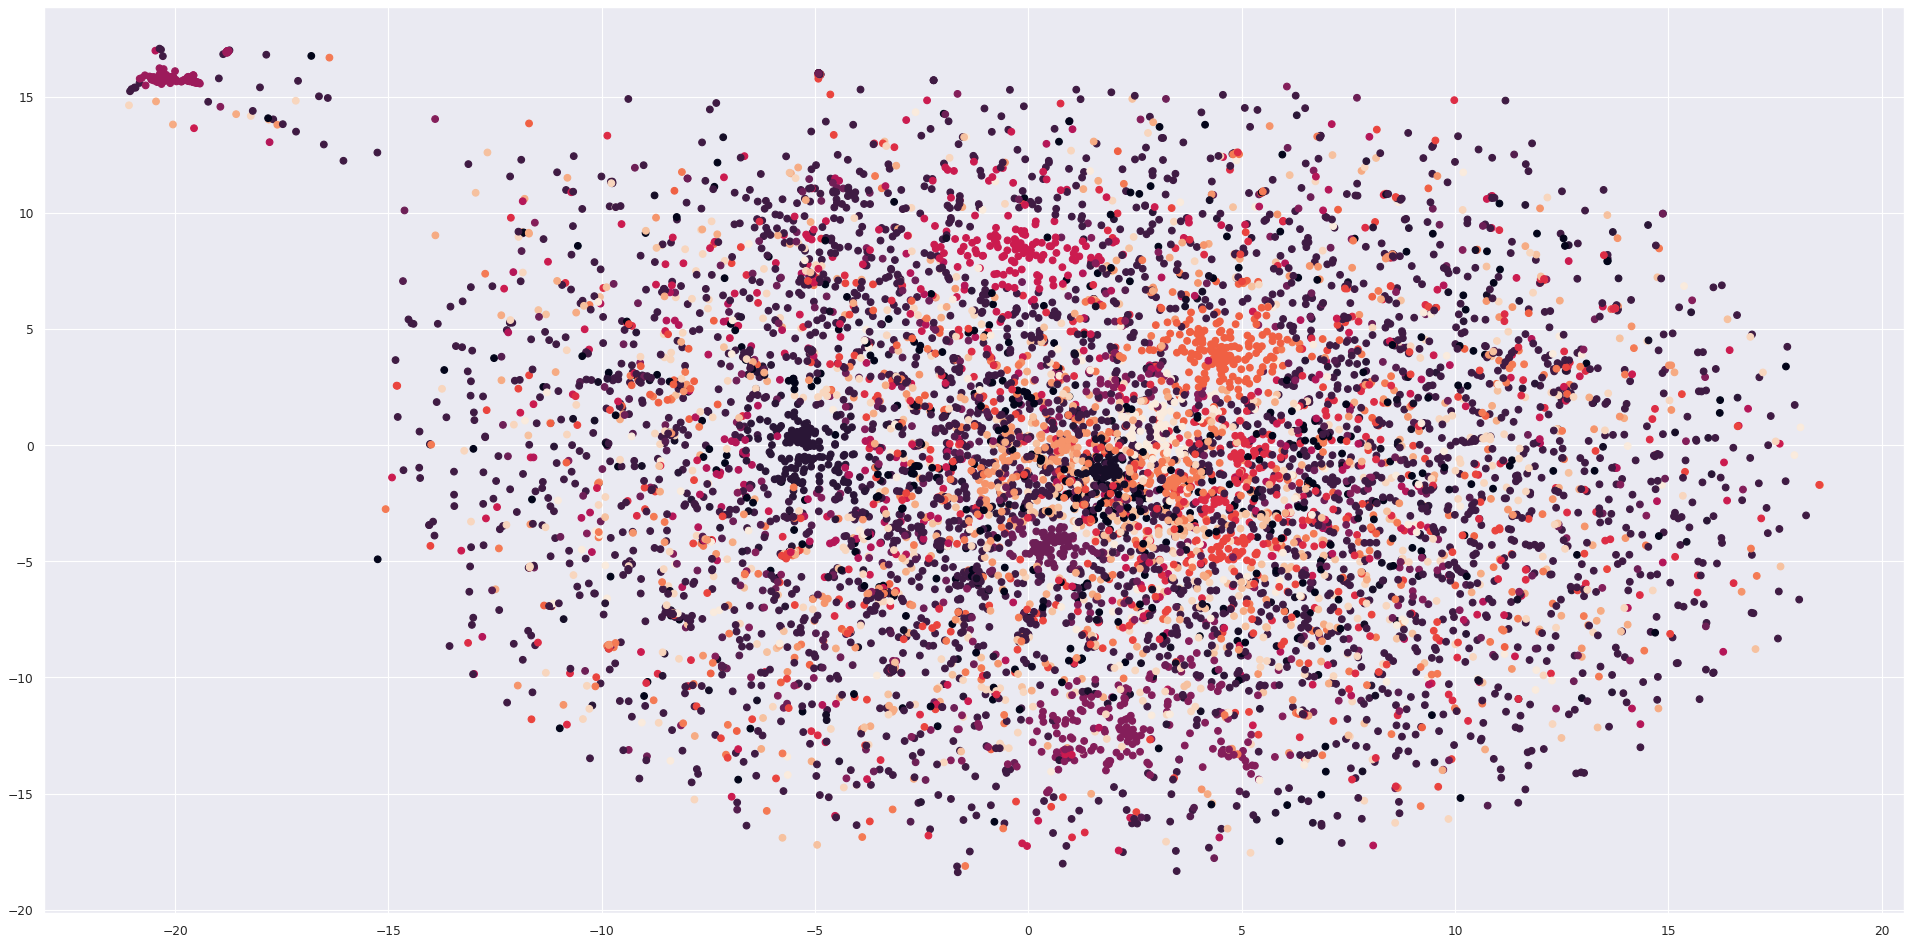

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 15), dpi=80)
plt.scatter(reduced_features_tsne[:, 0], reduced_features_tsne[:,1], c = kmeans_model.predict(features))

## 3 Dimensi

### PCA Dimensionality Reduction

In [39]:
from sklearn.decomposition import PCA

pca_3d = PCA(n_components = 3)
reduced_features_3d = pca_3d.fit_transform(features.toarray())
reduced_cluster_centers_3d = pca_3d.transform(synopsis_clusters.cluster_centers_)

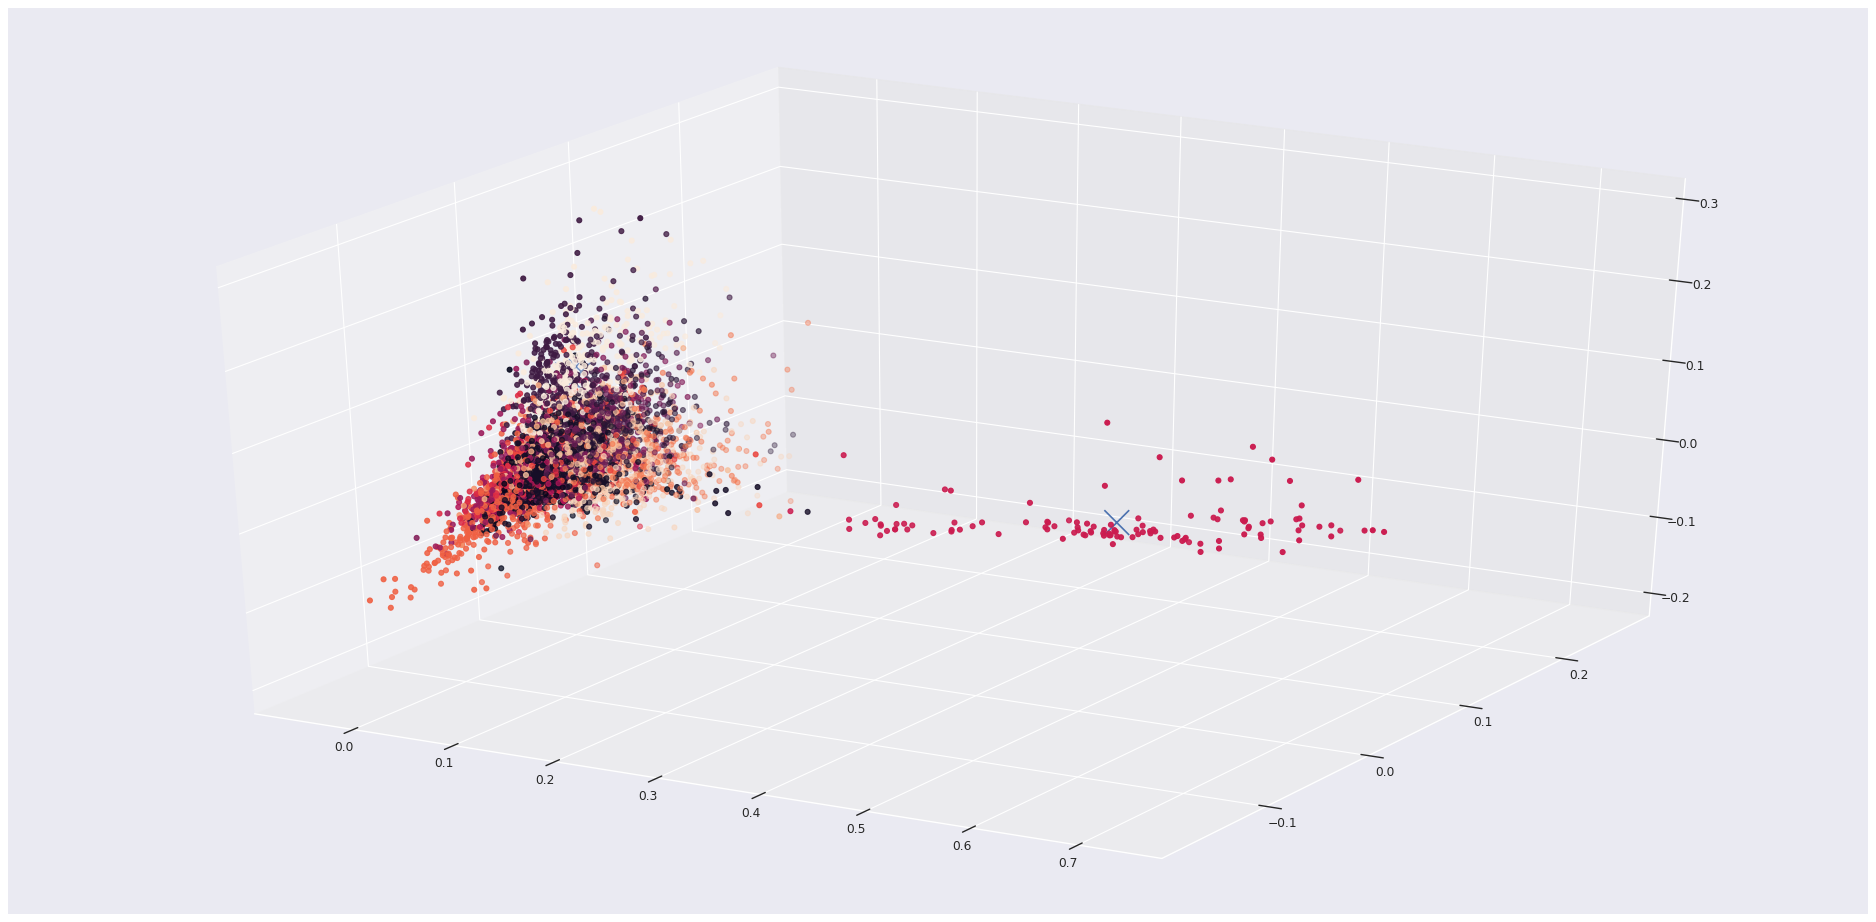

In [68]:
%matplotlib notebook
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

sns.set(style = "darkgrid")

fig = plt.figure(figsize=(30, 15), dpi=80)
ax = fig.add_subplot(111, projection = '3d')

x = reduced_features_3d[:, 0]
y = reduced_features_3d[:, 1]
z = reduced_features_3d[:, 2]

ax.scatter(x, y, z, c = synopsis_clusters.labels_)
ax.scatter(reduced_cluster_centers_3d[:, 0], reduced_cluster_centers_3d[:,1], reduced_cluster_centers_3d[:,2], marker='x', s=500, c='b')

plt.show()

### t-SNE Dimensionality Reduction

In [97]:
from sklearn.manifold import TSNE

tsne_3d = TSNE(n_components=3)
reduced_features_3d_tsne = tsne_3d.fit_transform(features.toarray())

In [113]:
import pickle

# Save Model
pickle.dump(tsne_3d, open('/content/gdrive/MyDrive/Upload/Akademik/Tugas Besar PBA/tsne_3d.sav', 'wb'))

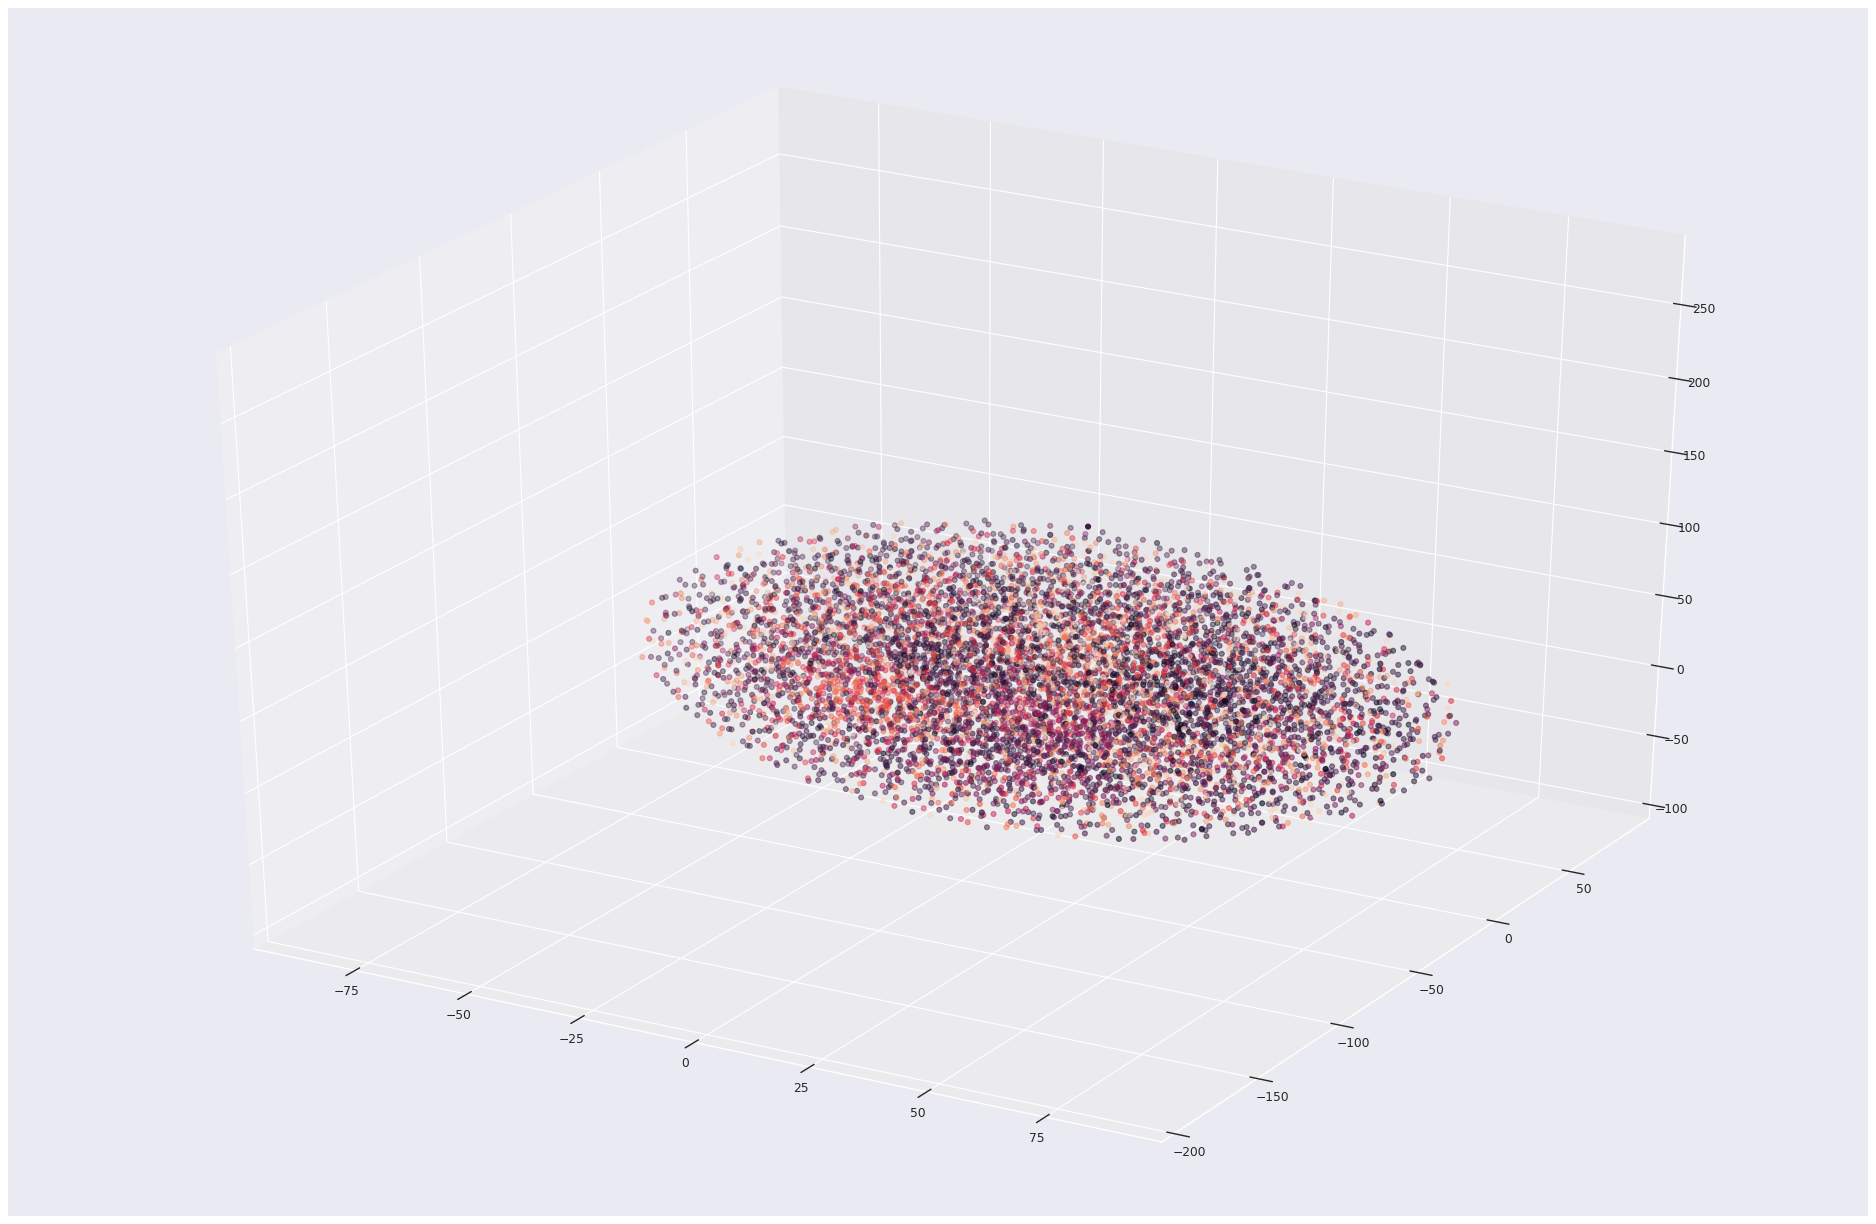

In [100]:
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

sns.set(style = "darkgrid")

fig = plt.figure(figsize=(30, 20), dpi=80)
ax = fig.add_subplot(111, projection = '3d')

x = reduced_features_3d_tsne[:, 0]
y = reduced_features_3d_tsne[:, 1]
z = reduced_features_3d_tsne[:, 2]

ax.scatter(x, y, z, c = synopsis_clusters.labels_)

plt.show()